In [43]:
pip install scikit-learn==1.5.0

Note: you may need to restart the kernel to use updated packages.


****Library Imports****

In [44]:
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score



****Loading the Dataset****

In [45]:
#  Load CSV from the correct path
df = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/train.csv')

# Display first few rows
print("📄 First 5 rows of train.csv:")
print(df.head())

📄 First 5 rows of train.csv:
  image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0


**Checking for Missing Values**

In [46]:
#Check for missing values
print("\n🧪 Missing values:")
print(df.isnull().sum())


🧪 Missing values:
image_id             0
healthy              0
multiple_diseases    0
rust                 0
scab                 0
dtype: int64


**Displaying Column Names**

In [47]:
print(df.columns)

Index(['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab'], dtype='object')


**Converting One-Hot Encoded Labels to a Single Column** and 
**Checking Label Distribution**

In [48]:
# Convert one-hot encoded label columns into a single 'label' column
label_cols = ['healthy', 'multiple_diseases', 'rust', 'scab']
df['label'] = df[label_cols].idxmax(axis=1)

# Check the first few rows
print(df.head())

# Check label distribution
print("\n Label distribution:")
print(df['label'].value_counts())

  image_id  healthy  multiple_diseases  rust  scab              label
0  Train_0        0                  0     0     1               scab
1  Train_1        0                  1     0     0  multiple_diseases
2  Train_2        1                  0     0     0            healthy
3  Train_3        0                  0     1     0               rust
4  Train_4        1                  0     0     0            healthy

 Label distribution:
label
rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: count, dtype: int64


**Visualizing Label Distribution**

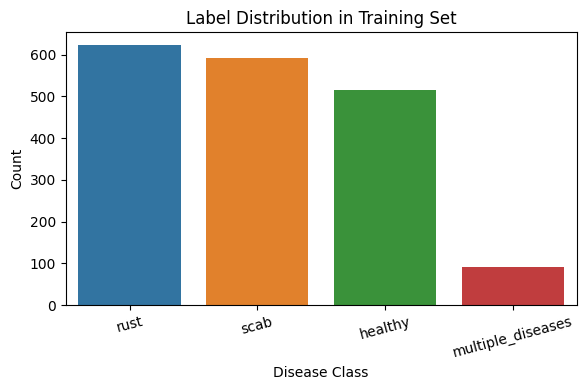

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.title("Label Distribution in Training Set")
plt.xlabel("Disease Class")
plt.ylabel("Count")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

1.Loops over every image in the dataset using df.iterrows() and tqdm for progress tracking.

2.Reads each image from disk using OpenCV (cv2.imread).

3.Resizes the image to 128×128 pixels to ensure uniform input size.

4.Converts the image to HSV color space, which is better for color-based analysis (e.g., plant disease detection).

5.Computes a 3D color histogram with 8×8×8 bins → results in a 512-dimensional feature vector.

6.Flattens and normalizes the histogram to a 1D array, then appends it to the features list.

7.Appends the corresponding label to the labels list to keep features and labels aligned.

In [50]:
# Image folder path
img_dir = '/kaggle/input/plant-pathology-2020-fgvc7/images'

# Function to extract color histogram features from an image
def extract_features(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))  # Resize to fixed size
    
    # Convert to HSV and compute color histogram
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8],
                        [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()  # Flatten to 1D feature vector
    return hist

# Extract features for all training images
features = []
labels = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    img_id = row['image_id']
    label = row['label']
    img_path = os.path.join(img_dir, img_id + '.jpg')
    
    feat = extract_features(img_path)
    features.append(feat)
    labels.append(label)

# Convert to numpy arrays
X = np.array(features)
y = np.array(labels)


100%|██████████| 1821/1821 [00:24<00:00, 73.66it/s]


X.shape = (1821, 512) → 512 handcrafted features per image

y.shape = (1821,) → corresponding disease labels

Fix Class Imbalance with RandomOverSampler(Manual)

In [51]:
print(set(labels))

{'multiple_diseases', 'healthy', 'rust', 'scab'}


In [52]:
print(np.unique(y))


['healthy' 'multiple_diseases' 'rust' 'scab']


In [53]:
import sklearn  
print(sklearn.__version__)

1.5.0


1.Import Required Libraries,  
2.Convert Feature Matrix and Labels to DataFrame,  
3.View Original Class Distribution,   
4.Separate Data by Class Labels,  
5.Identify the Maximum Class Size,   
6.Perform Oversampling to Balance Classes.   

In [54]:
import numpy as np
import pandas as pd
import sklearn  


from collections import Counter
from sklearn.utils import resample

# Assume X and y are already defined as your feature matrix and label vector

# Convert to DataFrame for easier manipulation
df_balanced = pd.DataFrame(X)
df_balanced['label'] = y

# Count original class distribution
print("Before oversampling:", dict(df_balanced['label'].value_counts()))

# Separate by class
grouped = [df_balanced[df_balanced['label'] == label] for label in df_balanced['label'].unique()]

# Find max class size
max_count = max([len(g) for g in grouped])

# Resample each class to max_count
resampled_groups = [resample(g, replace=True, n_samples=max_count, random_state=42) for g in grouped]



Before oversampling: {'rust': 622, 'scab': 592, 'healthy': 516, 'multiple_diseases': 91}


Create a Balanced Dataset

Import Required Libraries

Create DataFrame from Feature Matrix and Labels

Display Original Class Distribution

Separate Data by Class

Determine Maximum Class Size

Oversample Each Class to Match Maximum Count

Combine and Shuffle the Balanced Data

Extract Final Balanced Features and Labels

Display New Class Distribution After Balancing



In [55]:
import numpy as np
import pandas as pd
from sklearn.utils import resample

# Create DataFrame from X and y
df = pd.DataFrame(X)
df['label'] = y

# Print original class distribution
print("Before balancing:", dict(df['label'].value_counts()))

# Separate each class
classes = df['label'].unique()
grouped = [df[df['label'] == c] for c in classes]

# Find the maximum class count
max_count = max(len(g) for g in grouped)

# Oversample each class to max_count
resampled_groups = [
    resample(g, replace=True, n_samples=max_count, random_state=42)
    for g in grouped
]

# Concatenate and shuffle
df_balanced = pd.concat(resampled_groups).sample(frac=1, random_state=42).reset_index(drop=True)

# Final balanced features and labels
X_balanced = df_balanced.drop(columns=['label']).values
y_balanced = df_balanced['label'].values

# Print new class distribution
print("After balancing:", dict(pd.Series(y_balanced).value_counts()))


Before balancing: {'rust': 622, 'scab': 592, 'healthy': 516, 'multiple_diseases': 91}
After balancing: {'multiple_diseases': 622, 'healthy': 622, 'rust': 622, 'scab': 622}


Feature Scaling (Standardization or Normalization)
StandardScaler (mean=0, std=1)

In [56]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)


In [57]:
import joblib
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

Label Encoding

In [58]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y_balanced)

# Save encoder
joblib.dump(le, 'label_encoder.pkl')


['label_encoder.pkl']

Train-Test Split 

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)


Visualize Distribution

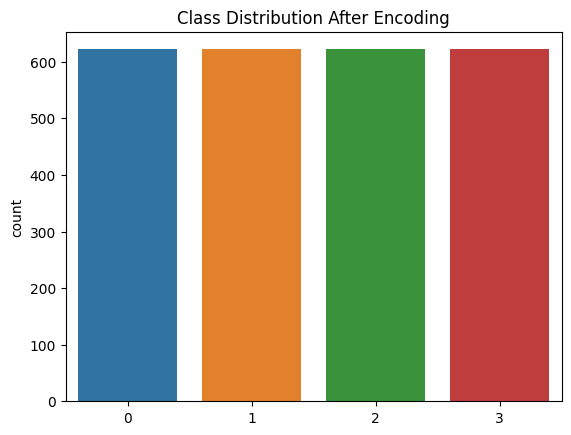

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y_encoded)
plt.title("Class Distribution After Encoding")
plt.show()


**Gradient Boosting**

**Import and Initialize**

In [61]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize the model
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)


**Train the Model**

In [62]:
gb_model.fit(X_train, y_train)


GradientBoostingClassifier(n_estimators=200, random_state=42)

**Make Predictions**

In [63]:
y_pred = gb_model.predict(X_test)


**Evaluate the Model**

Accuracy: 0.9799196787148594

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       125
           1       0.99      1.00      1.00       124
           2       0.99      0.99      0.99       125
           3       0.97      0.96      0.96       124

    accuracy                           0.98       498
   macro avg       0.98      0.98      0.98       498
weighted avg       0.98      0.98      0.98       498



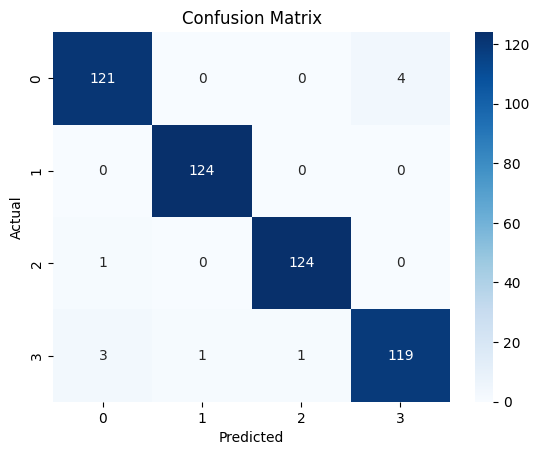

In [64]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [65]:
import joblib
joblib.dump(gb_model, 'gradient_boosting_model.pkl')


['gradient_boosting_model.pkl']

**SVM**

In [66]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Initialize SVM model
svm_model = SVC(
    kernel='rbf',         # 'linear', 'poly', 'rbf', or 'sigmoid'
    C=1.0,                 # Regularization parameter
    gamma='scale',         # Kernel coefficient
    random_state=42
)

In [67]:
# 2. Train the model
svm_model.fit(X_train, y_train)

SVC(random_state=42)

In [68]:
# 3. Predict on test data
y_pred = svm_model.predict(X_test)

Accuracy: 0.8293172690763052

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.83      0.79       125
           1       0.82      0.96      0.88       124
           2       0.96      0.74      0.84       125
           3       0.82      0.78      0.80       124

    accuracy                           0.83       498
   macro avg       0.84      0.83      0.83       498
weighted avg       0.84      0.83      0.83       498



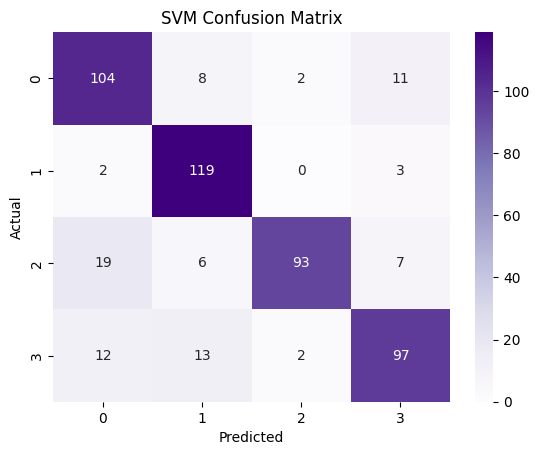

In [69]:
# 4. Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 5. Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

 **SVM Tuning with GridSearchCV**

In [70]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],                # Regularization
    'gamma': ['scale', 'auto', 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly']    # Try different kernels
}

# 2. Initialize SVM and GridSearch
svm = SVC()
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=5,                     # 5-fold cross-validation
    n_jobs=-1,                # Use all CPU cores
    verbose=2,
    scoring='accuracy'
)

# 3. Fit GridSearchCV
grid_search.fit(X_train, y_train)




Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.01, 0.001],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy', verbose=2)

In [71]:
# 4. Best parameters and estimator
print("Best Parameters:", grid_search.best_params_)
best_svm = grid_search.best_estimator_


Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}



Accuracy: 0.9317269076305221

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91       125
           1       0.98      1.00      0.99       124
           2       0.95      0.91      0.93       125
           3       0.92      0.88      0.90       124

    accuracy                           0.93       498
   macro avg       0.93      0.93      0.93       498
weighted avg       0.93      0.93      0.93       498



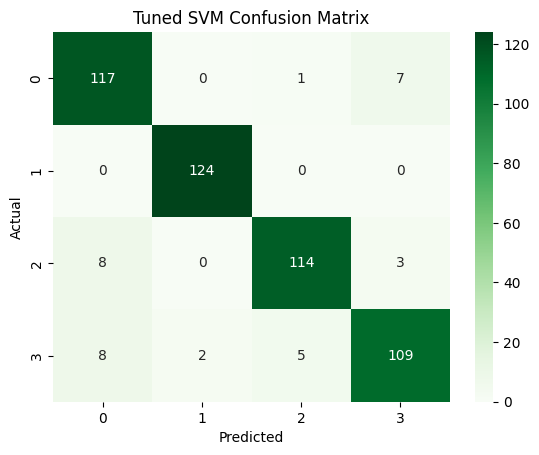

In [72]:
# 5. Evaluate on test set
y_pred = best_svm.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 6. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Tuned SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [73]:
import joblib
joblib.dump(best_svm, 'tuned_svm_model.pkl')


['tuned_svm_model.pkl']

Before SMOTE: Counter({'rust': 622, 'scab': 592, 'healthy': 516, 'multiple_diseases': 91})
After SMOTE: Counter({'scab': 622, 'multiple_diseases': 622, 'healthy': 622, 'rust': 622})
Fitting 5 folds for each of 18 candidates, totalling 90 fits
✅ Accuracy: 0.7771

📊 Classification Report:
                    precision    recall  f1-score   support

          healthy       0.59      0.78      0.68       125
multiple_diseases       0.92      0.99      0.95       124
             rust       0.87      0.73      0.79       125
             scab       0.80      0.60      0.69       124

         accuracy                           0.78       498
        macro avg       0.79      0.78      0.78       498
     weighted avg       0.79      0.78      0.78       498



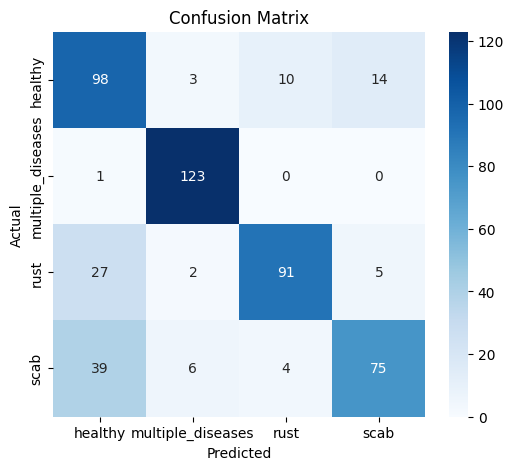

In [76]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# === Step 1: Balance classes ===
print("Before SMOTE:", Counter(y))
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print("After SMOTE:", Counter(y_res))

# === Step 2: Split & Scale ===
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, stratify=y_res, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === Step 3: Train SVM with GridSearch ===
param_grid = {
    'C': [1, 10, 100],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf', 'poly']
}
svc = SVC(class_weight='balanced', probability=True, random_state=42)
grid = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

# === Step 4: Evaluate ===
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [77]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.pipeline import Pipeline
from collections import Counter

# --- Replace this with your actual data ---
# Example synthetic data (you should use your preprocessed X and y instead)
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=20, n_classes=4, 
                           n_informative=10, n_redundant=5, weights=[0.6, 0.2, 0.15, 0.05], 
                           random_state=42)

# View original imbalance
print("Before balancing:", Counter(y))

# --- Step 1: Balance Data Using BorderlineSMOTE ---
smote = BorderlineSMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print("After balancing:", Counter(y_res))

# --- Step 2: Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, stratify=y_res, random_state=42)

# --- Step 3: Create SVM pipeline ---
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True, random_state=42))
])

# --- Step 4: Hyperparameter tuning ---
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': [0.01, 0.001],
    'svm__kernel': ['rbf']
}

grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

# --- Step 5: Evaluation ---
y_pred = grid.predict(X_test)

print("\n✅ Best Params:", grid.best_params_)
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Before balancing: Counter({0: 600, 1: 201, 2: 148, 3: 51})
After balancing: Counter({0: 600, 2: 600, 3: 600, 1: 600})
Fitting 3 folds for each of 6 candidates, totalling 18 fits

✅ Best Params: {'svm__C': 10, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
✅ Accuracy: 0.9416666666666667

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.89       120
           1       0.93      0.96      0.95       120
           2       0.94      0.97      0.95       120
           3       0.97      0.97      0.97       120

    accuracy                           0.94       480
   macro avg       0.94      0.94      0.94       480
weighted avg       0.94      0.94      0.94       480


🧩 Confusion Matrix:
 [[104   7   7   2]
 [  4 115   1   0]
 [  2   1 116   1]
 [  3   0   0 117]]


In [78]:
import joblib
joblib.dump(best_svm, 'tuned_svm_model2.pkl')


['tuned_svm_model2.pkl']

[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.9s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   1.8s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   1.5s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   1.3s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.8s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   1.8s
[CV] END .....................C=0.1, gamma=auto, kernel=poly; total time=   1.6s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.8s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.8s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   1.8s
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time=   1.1s
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time=   1.1s
[CV] END ..................C

In [80]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
import numpy as np

# Encode labels if not already encoded
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Oversample to fix imbalance
sm = BorderlineSMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y_encoded)
print("✅ After Oversampling:", Counter(y_res))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, stratify=y_res, random_state=42
)

# SVM pipeline with scaling
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True, class_weight='balanced', random_state=42))
])

# Parameter tuning
params = {
    'svm__C': [1, 10, 50],
    'svm__gamma': [0.01, 0.001],
    'svm__kernel': ['rbf']
}

# Grid search
grid = GridSearchCV(pipe, param_grid=params, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

# Predict and evaluate
y_pred = grid.predict(X_test)
print("✅ Best Params:", grid.best_params_)
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=[str(cls) for cls in le.classes_]))
print("✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ After Oversampling: Counter({0: 600, 2: 600, 3: 600, 1: 600})
Fitting 3 folds for each of 6 candidates, totalling 18 fits
✅ Best Params: {'svm__C': 50, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
✅ Accuracy: 0.9583333333333334
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       120
           1       0.96      0.99      0.98       120
           2       0.95      0.97      0.96       120
           3       0.96      1.00      0.98       120

    accuracy                           0.96       480
   macro avg       0.96      0.96      0.96       480
weighted avg       0.96      0.96      0.96       480

✅ Confusion Matrix:
 [[105   5   6   4]
 [  1 119   0   0]
 [  3   0 116   1]
 [  0   0   0 120]]


In [81]:
import joblib
joblib.dump(best_svm, 'tuned_svm_model3.pkl')

['tuned_svm_model3.pkl']

**Random Forest + GridSearchCV**

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# 1. Define the model
rf = RandomForestClassifier(random_state=42)

# 2. Define the hyperparameter space (reduced for speed)
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# 3. Setup RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,                  # Number of random combinations to try
    cv=3,                       # 3-fold CV for faster execution
    verbose=2,
    random_state=42,
    n_jobs=-1                   # Use all CPU cores
)

# 4. Fit on training data
random_search_rf.fit(X_train, y_train)




Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 150, 200]},
                   random_state=42, verbose=2)

🎯 Accuracy: 0.963855421686747

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       125
           1       1.00      0.98      0.99       124
           2       0.97      0.98      0.97       125
           3       0.94      0.95      0.95       124

    accuracy                           0.96       498
   macro avg       0.96      0.96      0.96       498
weighted avg       0.96      0.96      0.96       498



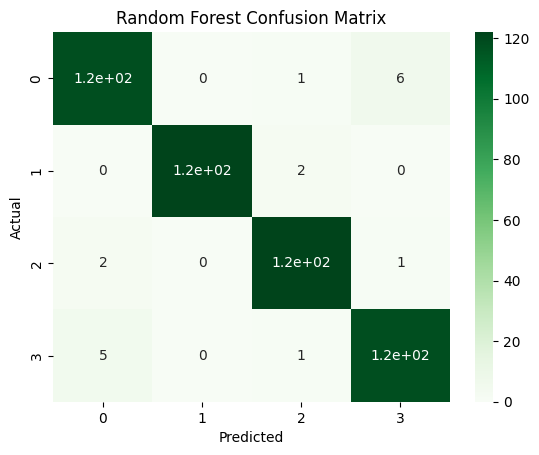

['tuned_random_forest_model.pkl']

In [75]:
# 5. Get best model
best_rf = random_search_rf.best_estimator_

# 6. Predict on test set
y_pred_rf = best_rf.predict(X_test)

# 7. Evaluation
print("🎯 Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred_rf))

# 8. Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, cmap='Greens')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 9. Save model
joblib.dump(best_rf, "tuned_random_forest_model.pkl")